### MATLAB CODE (by Bohar)

In [ ]:
clear all
close all
clc

addpath('/Users/austinreed/Desktop/Bohar_algorithm/KF_final')
addpath('/Users/austinreed/Desktop/Bohar_algorithm/KF_final/Aux_functions/')
addpath('/Users/austinreed/Desktop/Bohar_algorithm/KF_final/cbrewer/cbrewer/cbrewer')
addpath('/Users/austinreed/Desktop/Bohar_algorithm/KF_final/m_map')

cal98= calender_bohar(1998,1998);
cal_seson22 = cal98(335:365,:);
cal_6hr=zeros(31*4,4);
hr =[6 12 18 24];
cnt =1;
for i= 1:31
    for  j=1:4
        
        cal_6hr(cnt,:) = [cal_seson22(i,:) hr(j)];
        cnt=cnt+1;
        
    end 
end

%return

%observed track
trck =[ 2   1   -114.83   62.63    990.98    1998/12/13  12
        2   2   -103.28   62.53    988.70    1998/12/14  00
        2   3    -86.69   61.31    982.30    1998/12/14  12
        2   4    -75.76   60.88    977.19    1998/12/15  00
        2   5    -66.65   62.73    977.58    1998/12/15  12];
  
  xobs =trck(:,3);yobs =trck(:,4);
  ind =find(cal_6hr(:,3) >=13 &cal_6hr(:,3) <=15); % for a track between 12/03 -12/06
%--------------------------------------------------------------------------  
%                      Algorithm parameteres
%--------------------------------------------------------------------------
thres=-600;% Pa  % intensity threshold, set parameters: -600
bsize=400;      %blob size (grid point area), set parameter: 400
bc=28;         %block (object) connection parameter (search radius? in grid points), set parameter: 28
ti=1;          %set parameter: 1
%--------------------------------------------------------------------------  
%                      Reading MSLP data  
%--------------------------------------------------------------------------
path = '/Users/austinreed/Downloads/';  
%MERRA2
%file1 = 'slp6hr_spatialbandpass_winter19801981_anoms.nc';
file1 = 'slp6hr_spatialbandpass_dec1998_anoms.nc';
    
p = squeeze(ncread([path,file1],'__xarray_dataarray_variable__')); 
lat = squeeze(ncread([path,file1],'lat'));
lon = squeeze(ncread([path,file1],'lon')); 

%paf = p(21:321,201:331,:); %(25N-75N, -88W-20W)
%lona = lon(21:321);
%lata = lat(201:331);

paf =cat(1,p(361:720,:,:),p(1:360,:,:)); lona =[lon(361:720); lon(1:360)+360];lata=lat;
par = paf(241:720,221:331,:); %(25N-75N, -88W-20W)
lonr = lona(241:720);
latr = lata(221:331);
%--------------------------------------------------------------------------

%save('North_atlantic_extrpoical_strom_Pfa_6hr_DJF1980-1981.mat','paf','lona','lata')
ptest= paf(:,:,ind);
tracks = KF_tracking(ptest,ti,thres,bsize,bc);

%%
%--------------------------------------------------------------------------   
%                    Dropping irrevant tracks here
%--------------------------------------------------------------------------
 % Another subjective decision we have to made, which is about to the life of ETC 
 % It will be decided on the basis of number of time steps(6hr) a track
 % should survive to be considred as ETC
 trck_thr =4; %number of minimum time steps to be considered an ETC % current threshold: 1 day (4)
 j=1;
for i=1:size(tracks,2)
    
    if size(tracks(i).Centroid,1)>=trck_thr
        track_good(j)=tracks(i);
        j=j+1;
    end
    
end
%%

MCS_track_plot(track_good,lata,lona)
%clear track_good
%%
figure(2)
      m_proj('miller','lat',[25 85], 'lon',[180 360]);
      set(gca,'color',[.9 .99 1]);     % Trick is to set this *before* the patch call.
      m_coast('patch',[237/255 224/255 224/255],'linewidth',1);
      m_grid('linewi',1,'tickdir','out','xtick',[0 30 60 90 120 150 180 210 240 270 300 330 360  ],'ytick',[-80 -60 -40 -20 0 20 40 60 80],'fontsize',10 );
      
      m_line(360+xobs,yobs,'linewi',2,'marker','o','markersize',6,'color','b');
      m_line(360+xobs(1),yobs(1),'marker','h','MarkerFaceColor',[0 0 1],'MarkerEdgeColor','k','markersize',18);
      m_line(360+xobs(end),yobs(end),'marker','.','markersize',18,'color',[0 0 1]);
      
 %%     
 figure(3)
 ptest(ptest>=-300)=nan;
 xc=cal_6hr(ind,:);
  for i=1:12
 subplot(4,3,i)
  m_proj('miller','lat',[25 85], 'lon',[180 360]);
      set(gca,'color',[.9 .99 1]);     % Trick is to set this *before* the patch call.
      
      ff= squeeze(ptest(:,:,i));
      m_pcolor(lona,lata,ff');
      shading interp 
      m_coast('color',[0 0 0], 'linewi',1);
      m_grid('linewi',1,'tickdir','out','xtick',[0 30 60 90 120 150 180 240 300 360  ],'ytick',[-80 -60 -40 -20 0 20 40 60 80],'fontsize',10 );
      m_text(220,88, num2str(xc(i,:)))
     
 end    
 

### PYTHON ADAPTATION

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib as mpl
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature
from cartopy.feature import COASTLINE

In [2]:
#MSLP bandpass filtered data
f = '/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/slp6hr_spatialbandpass_dec1998_anoms.nc'
DS=xr.open_dataset(f)
DS

<xarray.Dataset>
Dimensions:                        (lat: 360, lon: 720, time: 124)
Coordinates:
  * lon                            (lon) float64 -180.0 -179.5 ... 179.0 179.5
  * lat                            (lat) float64 -90.0 -89.5 -89.0 ... 89.0 89.5
  * time                           (time) datetime64[ns] 1998-12-01 ... 1998-...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 ...

In [3]:
slp=DS['__xarray_dataarray_variable__']
lat=DS['lat']
lon=DS['lon']
paf=slp[:,230:331,184:321]
paf

<xarray.DataArray '__xarray_dataarray_variable__' (time: 124, lat: 101, lon: 137)>
[1715788 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -88.0 -87.5 -87.0 -86.5 ... -21.5 -21.0 -20.5 -20.0
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 73.0 73.5 74.0 74.5 75.0
  * time     (time) datetime64[ns] 1998-12-01 ... 1998-12-31T18:00:00

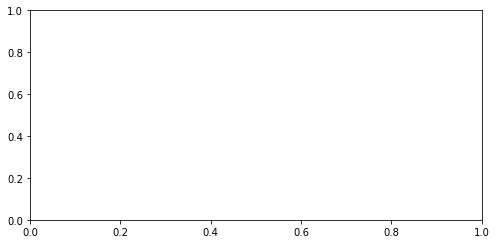

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Set the figure size
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# Random data for the contour plot
data = np.random.randn(800).reshape(10, 10, 8)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Method to change the contour data points
def animate(i):
    ax.clear()
    ax.contourf(data[:, :, i], cmap='plasma')

# Call animate method
ani = animation.FuncAnimation(fig, animate, 5, interval=50, blit=False)

# Display the plot
plt.show()

In [83]:
# Make the figure larger
#fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
#ax=plt.axes(projection=ccrs.Robinson())

# Add cyclic point to data
for i in range(0,len(paf['time'])):
#for i in range(0,3):
    # Make the figure larger
    fig = plt.figure(figsize=(11,8.5))
    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.Robinson())
    data=paf[i,:,:]
#data, lons = add_cyclic_point(data, coord=slp_filt['lon'])
    max_val=4000
    increment=800
    clevs = np.arange(start=-max_val, stop=max_val+increment, step=increment)
# Make a filled contour plot
    cs=ax.contourf(paf['lon'], paf['lat'], data,clevs,
            transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both')
    # Add coastlines
    ax.coastlines()
    # Add gridlines
    ax.gridlines()
    #plt.savefig('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/testing/dec1998_slp_time'+str(i))
    # Add colorbar
    cbar = plt.colorbar(cs,shrink=0.7,orientation='horizontal',label='Pascals')
    # Add title
    plt.title('SLP Bandpass Filtered Anomalies (Pa) (n=5-70): December 1998')
    plt.savefig('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/dec1998_slp_time'+str(i)+'.png')
    plt.close()

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


In [7]:
from PIL import Image
import glob
times=np.arange(0,124,1)

# Create the frames
frames = []
imgs_all=[]
for i in times:
    imgs ="/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/dec1998_slp_time"+str(i)+".png"
    new_frame = Image.open(imgs)
    frames.append(new_frame)
#print(frames[1:])
# Save into a GIF file that loops forever

frames[0].save('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/gif_file/png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

"\nframes[0].save('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/gif_file/png_to_gif.gif', format='GIF',\n               append_images=frames[1:],\n               save_all=True,\n               duration=300, loop=0)\n"

In [8]:
### Entire global domain
for i in range(0,len(slp['time'])):
#for i in range(0,3):
    # Make the figure larger
    fig = plt.figure(figsize=(11,8.5))
    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.Robinson())
    data=slp[i,:,:]
#data, lons = add_cyclic_point(data, coord=slp_filt['lon'])
    max_val=4000
    increment=800
    clevs = np.arange(start=-max_val, stop=max_val+increment, step=increment)
# Make a filled contour plot
    cs=ax.contourf(slp['lon'], slp['lat'], data,clevs,
            transform = ccrs.PlateCarree(),cmap='coolwarm',extend='both')
    # Add coastlines
    ax.coastlines()
    # Add gridlines
    ax.gridlines()
    #plt.savefig('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/testing/dec1998_slp_time'+str(i))
    # Add colorbar
    cbar = plt.colorbar(cs,shrink=0.7,orientation='horizontal',label='Pascals')
    # Add title
    plt.title('SLP Bandpass Filtered Anomalies (Pa) (n=5-70): December 1998')
    plt.savefig('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/global_domain_1998/dec1998_slp_time'+str(i)+'.png')
    plt.close()

/homes/areed29/.conda/envs/clim680/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


In [9]:
from PIL import Image
import glob
times=np.arange(0,124,1)

# Create the frames
frames = []
imgs_all=[]
for i in times:
    imgs ="/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/global_domain_1998/dec1998_slp_time"+str(i)+".png"
    new_frame = Image.open(imgs)
    frames.append(new_frame)
#print(frames[1:])
# Save into a GIF file that loops forever

frames[0].save('/project/xprecip/merra2_ncfiles/slp/global_slp_hourly/6hrly_global_slp/png_animation_test/gif_file/global_slp_dec1998.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

In [12]:
lon

<xarray.DataArray 'lon' (lon: 720)>
array([-180. , -179.5, -179. , ...,  178.5,  179. ,  179.5])
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5

In [34]:
#paf = slp[21:321,201:331,:] #(25N-75N, -88W-20W)
lona = lon[184:321]
lata = lat[230:331]
paf=slp[:,230:331,184:321]
paf

<xarray.DataArray '__xarray_dataarray_variable__' (time: 124, lat: 101, lon: 137)>
[1715788 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -88.0 -87.5 -87.0 -86.5 ... -21.5 -21.0 -20.5 -20.0
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 73.0 73.5 74.0 74.5 75.0
  * time     (time) datetime64[ns] 1998-12-01 ... 1998-12-31T18:00:00

In [39]:
#print(lata)
#print(lona)


In [36]:
b=slp[1:360,:,:]
a=slp[361:720,:,:]
print(b)
#paf=xr.concat([])
#paf =cat(1,p(361:720,:,:),p(1:360,:,:))
#lona =[lon(361:720); lon(1:360)+360]
#lata=lat
#par = paf(241:720,221:331,:) #(25N-75N, -88W-20W)
#lonr = lona(241:720);
#latr = lata(221:331);

<xarray.DataArray '__xarray_dataarray_variable__' (time: 123, lat: 360, lon: 720)>
[31881600 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * time     (time) datetime64[ns] 1998-12-01T06:00:00 ... 1998-12-31T18:00:00
